# Рынок заведений общественного питания Москвы

## Содержание: <a name="content"></a>

- [Описание проекта, описание данных и импорт библиотек](#description)

- [Шаг 1. Загрузка и предобработка данных](#step_1)
    - [Загрузка и просмотр данных](#loading)
    - [Предодработка данных](#preprocessing)
    - [Обработка названий](#names_processing)
    - [Обработка адресов](#address_processing)
    
- [Шаг №2. Анализ данных](#step_2)
    - [Соотношение количества заведений по виду и сетевым / несетевым](#number_of_network_and_non-network) 
    - [Для какого вида объекта общественного питания характерно сетевое распространение?](#type_of_object_network) 
    - [Что характерно для сетевых заведений?](#typical_for_network) 
    - [Среднее количество посадочных мест для каждого вида объекта](#avg_number_of_seats) 
    - [Топ-10 улиц по количеству объектов общественного питания](#top_10_streets) 
    - [Улицы с одним объектом общественного питания](#streets_single_object) 
    - [Распределение количества посадочных мест](#distribution_of_seats) 
    - [Выводы](#results)
    - [Интерактивная карта](#interactive_map)
    
- [Шаг №3. Презентация](#step_3)

## Импорт библиотек <a name="description"></a>

[к содержанию](#content)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re
from collections import Counter
import requests
from bs4 import BeautifulSoup

In [2]:
!pip install bokeh

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 8.8 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 16.7 MB/s eta 0:00:01
  Created wheel for bokeh: filename=bokeh-2.2.1-py3-none-any.whl size=9294618 sha256=6f4618eedf166dc0a846cdd6fb4f3c2f1475a0ef0a0dbdfe112b231b35a649af
  Stored in directory: /home/jovyan/.cache/pip/wheels/3b/ef/ce/1a2578df20c16fb3384699bc3cbcf9c91c04056ec0f318767c
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44619 sha256=f7af91e16ae28e9b5caab4f1e33ee75bb5dc02bf0f48889b67e7552fc10c36e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built bokeh PyYAML
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 93 kB 566 kB/s eta 0:00:011


In [4]:
# Установим pandas для географических данных:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 962 kB 814 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 24.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
!pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import geopandas  # для работы с датафреймом с геоданными
from IPython.display import IFrame, HTML
import folium  # библиотека для отображения данных на карте
from folium.plugins import HeatMap, Fullscreen
import yaml  # модуль для подгрузки токена в ноутбук

import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Загрузка и предобработка данных <a name="step_1"></a>

### Загрузка и просмотр данных <a name="loading"></a>

[к содержанию](#content)

Посмотрим исходную таблицу, наличие в ней пропусков, ошибок, типы и характеристики данных:

In [7]:
rests = pd.read_csv('/datasets/rest_data.csv')
rests

id             object_name chain object_type  \
0      151635                 СМЕТАНА   нет        кафе   
1       77874                  Родник   нет        кафе   
2       24309         Кафе «Академия»   нет        кафе   
3       21894              ПИЦЦЕТОРИЯ    да        кафе   
4      119365  Кафе «Вишневая метель»   нет        кафе   
...       ...                     ...   ...         ...   
15361  208537             Шоколадница    да        кафе   
15362  209264             Шоколадница    да        кафе   
15363  209186             Шоколадница    да        кафе   
15364  221900             Шоколадница    да        кафе   
15365  222535             Шоколадница    да        кафе   

                                                 address  number  
0             город Москва, улица Егора Абакумова, дом 9      48  
1      город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2              город Москва, Абельмановская улица, дом 6      95  
3                город Москва, Абрамцевская улица, дом 1      40  
4      город Москва, Абрамцевская улица, дом 9, корпус 1      50  
...                                                  ...     ...  
15361       город Москва, 3-й Крутицкий переулок, дом 18      50  
15362           город Москва, улица Земляной Вал, дом 33      10  
15363           город Москва, улица Земляной Вал, дом 33      20  
15364  город Москва, поселение Московский, Киевское ш...      36  
15365             город Москва, Ходынский бульвар, дом 4      10  

[15366 rows x 6 columns]

In [8]:
rests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [9]:
# Проверим наличие дубликатов
# Полные дубликаты
print(len(rests[rests.duplicated() == True]))
# Дубликаты с одинаковыми названием, адресом и количеством посадочных мест:
print(len(rests[rests.duplicated(['object_name', 'address'], keep = False) == True]))

0
344


#### Вывод

В таблице rests содержится информацию об объектах общественного питания. Она состоит из 6 столбцов и 15 366 строк: название, является ли заведение сетевым, тип, адрес и количество посадочных мест.

В таблице нет пропусков и неправильных типов данных. В столбце "object_name" в названиях заведений используется разный регистр букв, ковычки - необходимо привести к единому виду для дальнейшей работы. Так же присутствуют дубликаты, которые требуют обработки.

## Предодработка данных <a name="preprocessing"></a>

[к содержанию](#content)

In [10]:
# Создадим копию исходной таблицы:
rests_data = rests.copy()
# Переименовываю столбцы для удобства:
rests_data.columns = ['id', 'name', 'chain', 'type', 'address', 'seats'] 

Посмотрим, какие дубликаты мы нашли:

In [11]:
pd.set_option('max_colwidth', 100)
rests_data[rests_data.duplicated(['name', 'address'], keep = False) == True]\
    .groupby(['name', 'address', ], as_index = False)['id'].count().sort_values(by='id', ascending = False)

name  \
46   КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   
54                                   Кафе   
89                                   Лиор   
64                                   Кафе   
7                                    LIFT   
..                                    ...   
43         Ибрагимов Магомед Сулейманович   
42                     Замечательные люди   
41                         Закусочная KFC   
38                             Елки-Палки   
136                                  ЯСОН   

                                                           address  id  
46           город Москва, 2-я Бауманская улица, дом 5, строение 1  11  
54                    город Москва, 1-я Останкинская улица, дом 55   9  
89   город Москва, Шарикоподшипниковская улица, дом 13, строение 3   8  
64        город Москва, Тихорецкий бульвар, владение 1, строение 1   6  
7            город Москва, Багратионовский проезд, дом 7, корпус 1   6  
..                                                             ...  ..  
43           город Москва, улица Сущёвский Вал, дом 5, строение 12   2  
42                             город Москва, улица Ильинка, дом 13   2  
41                  город Москва, проспект Мира, дом 211, корпус 2   2  
38                  город Москва, проспект Мира, дом 211, корпус 2   2  
136                           город Москва, улица Косыгина, дом 15   2  

[137 rows x 3 columns]

In [12]:
rests_data[rests_data.duplicated(['name', 'address'], keep = False) == True].groupby(['name', 'address'], as_index = False)['id']\
.count().sort_values(by='id', ascending = False).head()

name  \
46  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   
54                                  Кафе   
89                                  Лиор   
64                                  Кафе   
7                                   LIFT   

                                                          address  id  
46          город Москва, 2-я Бауманская улица, дом 5, строение 1  11  
54                   город Москва, 1-я Останкинская улица, дом 55   9  
89  город Москва, Шарикоподшипниковская улица, дом 13, строение 3   8  
64       город Москва, Тихорецкий бульвар, владение 1, строение 1   6  
7           город Москва, Багратионовский проезд, дом 7, корпус 1   6

In [13]:
rests_data[rests_data['address'] == 'город Москва, 2-я Бауманская улица, дом 5, строение 1']

id                                  name chain        type  \
2374  28603  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет    столовая   
2375  28604  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет    столовая   
2376  28605  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет   кафетерий   
2377  28606  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет       буфет   
2378  28607  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет  закусочная   
2379  28609  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет       буфет   
2380  28610  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет    столовая   
2381  28611  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет    столовая   
2382  28615  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет    столовая   
2383  28616  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет  закусочная   
2384  28617  КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА   нет    столовая   

                                                    address  seats  
2374  город Москва, 2-я Бауманская улица, дом 5, строение 1    100  
2375  город Москва, 2-я Бауманская улица, дом 5, строение 1    150  
2376  город Москва, 2-я Бауманская улица, дом 5, строение 1     35  
2377  город Москва, 2-я Бауманская улица, дом 5, строение 1     16  
2378  город Москва, 2-я Бауманская улица, дом 5, строение 1     16  
2379  город Москва, 2-я Бауманская улица, дом 5, строение 1     30  
2380  город Москва, 2-я Бауманская улица, дом 5, строение 1    200  
2381  город Москва, 2-я Бауманская улица, дом 5, строение 1    100  
2382  город Москва, 2-я Бауманская улица, дом 5, строение 1    168  
2383  город Москва, 2-я Бауманская улица, дом 5, строение 1     64  
2384  город Москва, 2-я Бауманская улица, дом 5, строение 1    108

Среди 15 366 значений есть 344, для которых дублируются название и адрес. На примере комбината питания Бауманки видно, что это явно одно заведение, но с разными типами и количеством мест. Учитывая количество дубликатов, можно просто удалить их, оставив в популяции первые строки.

In [14]:
rests_data = rests_data.drop_duplicates(subset = ['name', 'address']).reset_index(drop=True)

#### Проверим корректность данных в отдельных столбцах

In [15]:
for column in ['chain', 'seats']:
    print(rests_data[column].unique())

['нет' 'да']
[  48   35   95   40   50  240   10   90  150  120    5   24  140   32
  270  320    7    2  160   20   30  110    6  192   65   45    4  125
  100   49   63   70   22   56   38  220   78    3   80   46   15   96
   60   47  180  250  200   25   12   14   16  420   98   75   34   43
   54  580  159    0   28   64   67   42  124   82   36  114    8   71
   18  158   55  196   44   76  144   41   26   68  143  198   79    1
   86  148  190  202  131   52   92  300   85  102   88   84  246   81
   94   23   37   39   99   61   11  130   74  128  106   58  260   27
   19   29   13    9  168  350   93   33  105  239  104   17   62  230
  132   87   89  170   83   21  108  210   51   53  115   66  280  126
   97  356  156  428  380  138   72  118  139  236  450  194  330  225
  500  112  109  146  306  272  290  176  175  252  122  400  542  424
  216 1040  660  282  145  395  188  149  157  103   69  184  185  121
  187  247  217  313  155  310  328  101  226  398  430  166  30

In [16]:
rests_data.query('seats == 0')

id                 name chain                               type  \
135    115498      Пекарня & Донер   нет                         закусочная   
152    152556        Шаурма в пите   нет  предприятие быстрого обслуживания   
155    149568                 Суши   нет  предприятие быстрого обслуживания   
188    126956   Шаурма, куры-гриль   нет  предприятие быстрого обслуживания   
193    149531   Шаурма, куры-гриль   нет  предприятие быстрого обслуживания   
...       ...                  ...   ...                                ...   
15129  211228                МИЛТИ    да          магазин (отдел кулинарии)   
15130  211221                МИЛТИ    да          магазин (отдел кулинарии)   
15131  211209  Готовые блюда Милти    да  предприятие быстрого обслуживания   
15132  208477                Милти    да  предприятие быстрого обслуживания   
15133  211201                Милти    да          магазин (отдел кулинарии)   

                                                         address  seats  
135               город Москва, Бутырская улица, дом 9, корпус 2      0  
152             город Москва, Варшавское шоссе, дом 72, корпус 2      0  
155    город Москва, улица Маршала Василевского, дом 3, корпус 1      0  
188                 город Москва, 1-я Владимирская улица, дом 21      0  
193              город Москва, 2-я Владимирская улица, дом 44/10      0  
...                                                          ...    ...  
15129                   город Москва, Дубравная улица, дом 34/29      0  
15130                       город Москва, Пятницкое шоссе, дом 3      0  
15131                    город Москва, Ореховый бульвар, дом 22А      0  
15132               город Москва, 3-й Крутицкий переулок, дом 18      0  
15133                  город Москва, Новослободская улица, дом 4      0  

[1579 rows x 6 columns]

Для некоторых заведений в столбце `seats` указано значение 0. Эти заведения, где не предусмотрены посадочные места. Данные корректны.

Посмотрим какие есть типы заведений в таблице:

In [17]:
type_rests = rests_data['type'].unique().tolist()
type_rests

['кафе',
 'столовая',
 'закусочная',
 'предприятие быстрого обслуживания',
 'ресторан',
 'кафетерий',
 'буфет',
 'бар',
 'магазин (отдел кулинарии)']

Для краткости переименовываю некоторые виды заведений:

In [18]:
rests_data['type'] = rests_data['type'].replace('предприятие быстрого обслуживания', 'фастфуд')
rests_data['type'] = rests_data['type'].replace('магазин (отдел кулинарии)', 'кулинария')

### Обработка названий <a name="names_processing"></a>

[к содержанию](#content)

Как уже отмечалось выше, названия имеют разный формат. Нам необходимо унифицировать их (привести к нижнему регистру, убрать спец. символы и лишние слова, привести к одному названию внутри одной сети)

In [19]:
# Посмотрим на количество уникальных названий:
count_unique_0 = rests_data['name'].nunique()

In [20]:
# Приведем все к нижнему регистру
rests_data['name'] = rests_data['name'].str.lower()
rests_data.head()

id                    name chain  type  \
0  151635                 сметана   нет  кафе   
1   77874                  родник   нет  кафе   
2   24309         кафе «академия»   нет  кафе   
3   21894              пиццетория    да  кафе   
4  119365  кафе «вишневая метель»   нет  кафе   

                                             address  seats  
0         город Москва, улица Егора Абакумова, дом 9     48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1     35  
2          город Москва, Абельмановская улица, дом 6     95  
3            город Москва, Абрамцевская улица, дом 1     40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1     50

In [21]:
count_unique_1 = rests_data['name'].nunique()
print('Приведение столбца "name" к нижнему регистру уменьшило количество уникальных значений на {} шт. или на {:.1%} от исходного количества'.format(count_unique_0 - count_unique_1, (count_unique_0 - count_unique_1)/count_unique_0))

Приведение столбца "name" к нижнему регистру уменьшило количество уникальных значений на 469 шт. или на 4.5% от исходного количества


In [22]:
# Уберем спец. символы и заменим 'ё' на 'е':
for i in ['»', '«', '.']:
    rests_data['name'] = rests_data['name'].str.replace(i, '')
rests_data['name'] = rests_data['name'].str.replace('ё', 'е')
count_unique_2 = rests_data['name'].nunique()
print('Исключение спецсимволов уменьшило количество уникальных значений на {} шт. или на {:.1%} от исходного количества'.format(count_unique_1 - count_unique_2, (count_unique_1 - count_unique_2)/count_unique_0))

Исключение спецсимволов уменьшило количество уникальных значений на 92 шт. или на 0.9% от исходного количества


In [23]:
# Бегло посмотрим названия заведений в таблице: 
#rests_data['name'].unique().tolist()
rests_data.groupby('name')['id'].nunique().sort_values(ascending=False).head(30)

name
столовая                    320
кафе                        241
шаурма                      240
шоколадница                 156
kfc                         153
макдоналдс                  147
бургер кинг                 136
теремок                      93
домино'с пицца               90
крошка картошка              89
пекарня                      80
буфет                        75
суши wok                     72
милти                        72
папа джонс                   51
додо пицца                   49
школьно-базовая столовая     44
кофе с собой                 43
чайхона №1                   41
донер кебаб                  41
якитория                     38
хинкальная                   38
кафетерий                    37
выпечка                      36
subway                       34
кофе хаус                    33
кофейня                      33
хлеб насущный                32
тануки                       32
starbucks                    28
Name: id, dtype: int64

Найдем частоиспользуемые в названиях слова:

In [24]:
# Используем лемматизацию:

words = (rests_data['name'].str.cat(sep=' ').split())
lemmas = pd.Series(Counter(words), name='lemmas').sort_values(ascending = False)
lemmas[:20]

кафе           1658
столовая       1562
школа           653
ресторан        593
при             592
№               513
гбоу            455
пицца           365
бар             314
шаурма          308
буфет           286
суши            252
кофе            232
пекарня         212
и               195
бургер          195
шоколадница     186
kfc             186
макдоналдс      168
кинг            166
Name: lemmas, dtype: int64

В названиях часто используются общие названия (кафе, столовая, ресторан), которые могут мешать при анализе данных.

In [25]:
# Если название совпадает с типом заведения, то оставляем его без изменений
# в противном случае, убераем общее тип заведения из названия
def names_normaliser(name):

    for i in type_rests:
        if i == name:
            return name
        else: 
            new_name = name.replace(i, '')
            return new_name

# Оставляем только название сети для перечисленных сетей       
def chains_normaliser(name):
        
    for chain_name in ['шоколадница', 'бургер кинг', 'макдоналдс', 'kfc', 'теремок', 'домино', 'крошка картошка',
                      'subway', 'starbucks', 'му-му', 'cofix', 'кулинарная лавка братьев караваевых', 'якитория', 
                       'мята lounge', 'coffeeshop', 'буше', 'прайм стар', 'иль патио', 'маки-маки', 'ваби-саби', 
                       'ванвок', 'costa coffee', 'штолле', 'папа джонс', 'икеа', 'суши wok', 'гудман', 'милти']:
        if chain_name in name:
            name = chain_name
    return name

In [26]:
rests_data['name'] = rests_data['name'].apply(names_normaliser)
rests_data['name'] = rests_data['name'].apply(chains_normaliser)

In [27]:
count_unique_3 = rests_data['name'].nunique()
print('Удаление общих названий уменьшило количество уникальных значений на {} шт. или на {:.1%} от исходного количества'.format(count_unique_2 - count_unique_3, (count_unique_2 - count_unique_3)/count_unique_0))

Удаление общих названий уменьшило количество уникальных значений на 127 шт. или на 1.2% от исходного количества


### Обработка адресов <a name="address_processing"></a>

[к содержанию](#content)

Добавим столбец `city` с указанием города (по умолчанию он равен Москве, кроме других городов). И добавим столбец с адресом без указания города:

In [28]:
rests_data['new_address'] = rests_data['address'].str.replace('город Москва, ', '')

In [29]:
def city(address):
    if 'Зеленоград' in address:
        address = 'Зеленоград'
    elif 'Московский' in address:
        address = 'Московский'
    elif 'Щербинка' in address:
        address = 'Щербинка'
    elif 'Троицк' in address:
        address = 'Троицк'
    else: address = 'Москва'
    return address
rests_data['city'] = rests_data['address'].apply(city)

In [30]:
rests_data.groupby('city')['id'].count()
for i in ['город Зеленоград, ', 'город Московский, ', 'город Щербинка, ', 'город Троицк, ','город Москва, ']:
    rests_data['new_address'] = rests_data['new_address'].str.replace(i, '')
rests_data.head()

id              name chain  type  \
0  151635           сметана   нет  кафе   
1   77874            родник   нет  кафе   
2   24309          академия   нет  кафе   
3   21894        пиццетория    да  кафе   
4  119365   вишневая метель   нет  кафе   

                                             address  seats  \
0         город Москва, улица Егора Абакумова, дом 9     48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1     35   
2          город Москва, Абельмановская улица, дом 6     95   
3            город Москва, Абрамцевская улица, дом 1     40   
4  город Москва, Абрамцевская улица, дом 9, корпус 1     50   

                           new_address    city  
0         улица Егора Абакумова, дом 9  Москва  
1  улица Талалихина, дом 2/1, корпус 1  Москва  
2          Абельмановская улица, дом 6  Москва  
3            Абрамцевская улица, дом 1  Москва  
4  Абрамцевская улица, дом 9, корпус 1  Москва

In [31]:
# Теперь в начале строки адреса до запятой, как правило, идет название улицы. Выделим ее в отдельный столбец:

rests_data['street'] = rests_data['new_address'].str.split(',',expand=True)[0]
rests_data.head()

id              name chain  type  \
0  151635           сметана   нет  кафе   
1   77874            родник   нет  кафе   
2   24309          академия   нет  кафе   
3   21894        пиццетория    да  кафе   
4  119365   вишневая метель   нет  кафе   

                                             address  seats  \
0         город Москва, улица Егора Абакумова, дом 9     48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1     35   
2          город Москва, Абельмановская улица, дом 6     95   
3            город Москва, Абрамцевская улица, дом 1     40   
4  город Москва, Абрамцевская улица, дом 9, корпус 1     50   

                           new_address    city                 street  
0         улица Егора Абакумова, дом 9  Москва  улица Егора Абакумова  
1  улица Талалихина, дом 2/1, корпус 1  Москва       улица Талалихина  
2          Абельмановская улица, дом 6  Москва   Абельмановская улица  
3            Абрамцевская улица, дом 1  Москва     Абрамцевская улица  
4  Абрамцевская улица, дом 9, корпус 1  Москва     Абрамцевская улица

**Вывод**:
В ходе предобработки данных были удалены дубликаты. Проверили данные по отдельным столбцам: обработаны названия заведений и адреса.

## Шаг №2. Анализ данных <a name="step_2"></a>

### Соотношение количества заведений по виду и сетевым / несетевым <a name="number_of_network_and_non-network"></a>

[к содержанию](#content)

Text(0, 0.5, 'Количество заведений')

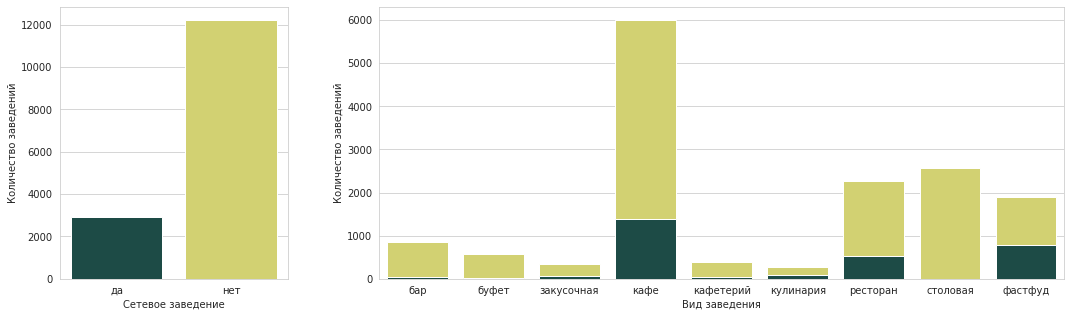

In [32]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,5), gridspec_kw={'width_ratios': [1, 3]})
sns.barplot(x='chain', y='id', data=rests_data.groupby('chain', as_index = False)['id'].count(), ax = axes[0], 
            palette =['#15534C', '#E2E062'])
axes[0].set_xlabel('Сетевое заведение')
axes[0].set_ylabel('Количество заведений')
sns.barplot(x='type', y='id', data = rests_data.groupby('type', as_index = False)['id'].count(), color='#E2E062', ax = axes[1])
sns.barplot(x='type', y='id', data = rests_data.groupby(['type', 'chain'], as_index = False)['id'].count().query('chain == "да"'), 
            color='#15534C', ax = axes[1])
axes[1].set_xlabel('Вид заведения')
axes[1].set_ylabel('Количество заведений')

- 19% заведений - сетевые, 81% - несетевые
- 6 тысяч заведений - кафе, примерно по 2 тысячи - столовые, рестораны и фастфуд, остальных - меньше 1 тысячи
- соотношение сетевых и несетвых заведений для каждого вида можно посмотреть отдельно

### Для какого вида объекта общественного питания характерно сетевое распространение? <a name="type_of_object_network"></a>

[к содержанию](#content)

In [33]:
bytypechain = rests_data.pivot_table(index = 'type', columns = 'chain', values = 'id', aggfunc = 'count').reset_index()
bytypechain = bytypechain.append(pd.DataFrame([['в среднем', bytypechain['да'].sum(), bytypechain['нет'].sum()]], 
                                              columns = ['type', 'да', 'нет']))
bytypechain['%сетей'] = bytypechain['да'] / (bytypechain['да'] + bytypechain['нет']) 
bytypechain = bytypechain.sort_values(by = '%сетей', ascending = False).reset_index()
bytypechain['100%'] = 1
bytypechain.head()

chain  index       type    да    нет    %сетей  100%
0          8    фастфуд   782   1104  0.414634     1
1          5  кулинария    78    194  0.286765     1
2          6   ресторан   539   1733  0.237236     1
3          3       кафе  1384   4619  0.230551     1
4          0  в среднем  2940  12219  0.193944     1

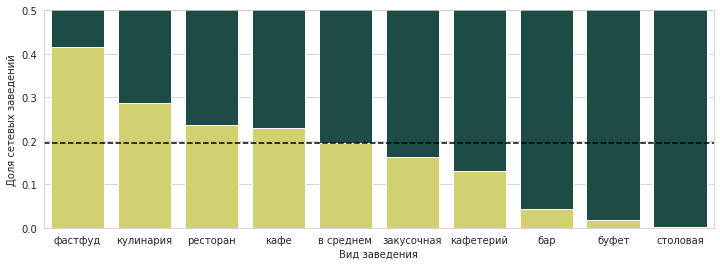

In [34]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(x='type', y='100%', data = bytypechain, color='#15534C')
ax = sns.barplot(x='type', y='%сетей', data = bytypechain, color='#E2E062')
ax.set_xlabel('Вид заведения')
ax.set_ylabel('Доля сетевых заведений')
ax.set_ylim(0,0.5)
plt.axhline(y=bytypechain.loc[4, '%сетей'], color='black', linestyle='--')

- в среднем доля сетевых заведений - 19%
- наивысшая доля у фастфуда - больше 40%, чуть выше среднего - у кулинарий, ресторанов и кафе, ниже 19% у закусочных, кафетериев, баров, буфетов
- сетевых столовых нет вообще

### Что характерно для сетевых заведений? <a name="typical_for_network"></a>

[к содержанию](#content)

Много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

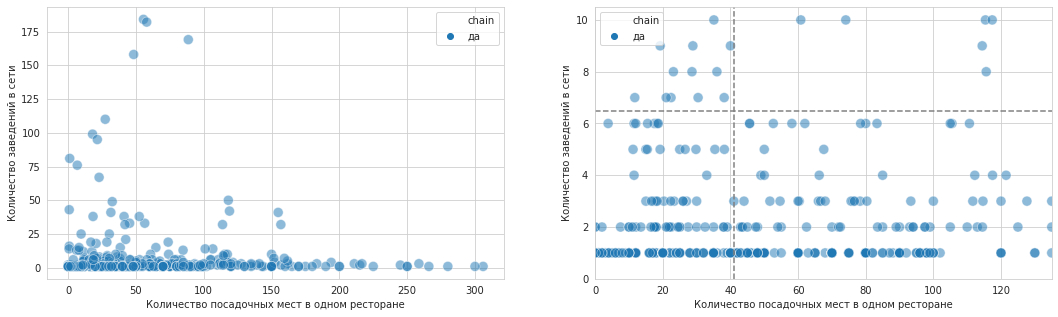

In [35]:
namechain = rests_data[rests_data['chain'] == 'да'].groupby(['name', 'chain'], as_index = False).agg({'id':'count', 'seats':'sum'})
namechain['seats_per_rest'] = namechain['seats'] / namechain['id']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,5))
sns.scatterplot(x="seats_per_rest", y="id", hue = 'chain', alpha = 0.5, s = 100, data = namechain, ax = axes[1])
axes[1].set_xlim(0,namechain['seats_per_rest'].quantile(0.9))
axes[1].set_ylim(0,namechain['id'].quantile(0.9)+0.5)
axes[1].set_xlabel('Количество посадочных мест в одном ресторане')
axes[1].set_ylabel('Количество заведений в сети')

sns.scatterplot(x="seats_per_rest", y="id", hue = 'chain', alpha = 0.5, s = 100, data = namechain, ax = axes[0])
axes[0].set_xlabel('Количество посадочных мест в одном ресторане')
axes[0].set_ylabel('Количество заведений в сети')
plt.axhline(y=6.5, color='grey', linestyle='--')
plt.axvline(x=41, color='grey', linestyle='--')

Первый график - полный, второй - ограничен до 90 перцентиля по обоим показателям, чтобы учитывать только нормальные данные. По правом (нормализованному) графику можно сделать выводы:

Несмотря на приведение названий заведений к единому формату, большая часть сетевых заведений имеет только 1 заведение. Это может быть как из-за того, разные заведения названы по-разному, так и из-за неполных данных, или того, что другие заведения находятся в других регионах. Это нельзя считать ошибкой.
У большинства сетей 1-2 заведения и до 50 посадочных мест.
За редкими исключениями, второе и следующие заведения появляются при среднем количестве от 10 мест, то есть некоторые маленькие заведения увеличивают количество, но не размер.
Можно выделить две группы сетей с сумарным количеством мест от 200: первые - 6-10 заведений до 40 мест каждое, вторые - 40-120 мест в 1-6 заведении. Сетей, где было бы больше и 6 заведений, и 40 мест в каждом, очень мало.
То есть можно говорить о том, что заведения до 40 мест расширяют сеть, а большие (больше 40 мест) ограничиваются 1-3, реже - до 6, причем вторых больше.
На левом графике видно, что тенденция сохраняется: большие сети (>50 заведений) ограничены 50-60 местами (за одним исключением), а большие заведения не масштабируются.
В итоге, можно говорить о двух стратегиях, причем сетей с несколькими большими ресторанами гораздо больше, чем больших сетей с небольшими ресторанами.


### Среднее количество посадочных мест для каждого вида объекта <a name="avg_number_of_seats"></a>

[к содержанию](#content)

Какой вид предоставляет в среднем самое большое количество посадочных мест?

Text(17.231250000000003, 0.5, 'Количество заведений')

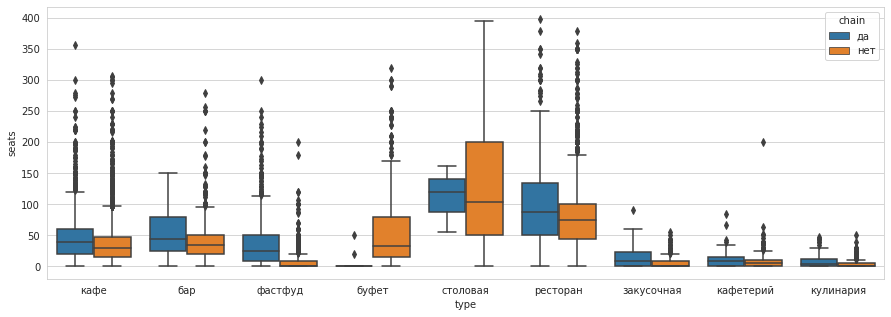

In [36]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="type", y="seats", hue = 'chain', 
            data=rests_data.groupby(['id', 'type', 'chain'], as_index = False)['seats'].sum().query('seats < 400'))
ax.set_xlabel('Вид заведения')
ax.set_ylabel('Количество заведений')

График ограничен сверху 400 местами.

- для большинства типов заведений характерно то, что в сетевых заведениях больше мест, чем в несетевых - как по медиане, так и по верхним значениями; исключением являются буфеты и столовые, которые почти не бывают сетевыми, и рестораны;
- закусочные, кафетерии и кулинарии, как и следовало ожидать, очень маленькие - половина не достигает 10 человек;
- медиана кафе, баров и фастфудов ниже 50 человек;
- самые большие - рестораны и столовые, их медиана близка к 100 людям. Рестораны также являются единственной категорией, в которые сетевые больше, чем несетевые.

### Топ-10 улиц по количеству объектов общественного питания <a name="top_10_streets"></a>

[к содержанию](#content)

Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Для начала загрузим классификатор улиц Москвы с data.mos.ru (https://data.mos.ru/classifier/2044?pageNumber=1&countPerPage=10) и подтяним их к основной таблице:

In [37]:
mosopen = pd.read_excel('mosopen.xlsx')
mosopen = mosopen.drop_duplicates(subset = 'UM_NAMEF').reset_index(drop=True)
mosopen = mosopen[['UM_NAMEF', 'UM_CODE']]
mosopen.head(2)

UM_NAMEF  UM_CODE
0  1-й Ирининский переулок     8880
1  2-й Ирининский переулок     8890

In [38]:
rests_data = rests_data.merge(mosopen, left_on='street', right_on='UM_NAMEF', how = 'left')
del rests_data['UM_NAMEF']
rests_data.columns = ['id', 'name', 'chain', 'type', 'address', 'seats', 'new_address', 'city', 'street','code']
rests_data['code'] = rests_data['code'].astype(str)
rests_data.head(2)

id     name chain  type  \
0  151635  сметана   нет  кафе   
1   77874   родник   нет  кафе   

                                             address  seats  \
0         город Москва, улица Егора Абакумова, дом 9     48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1     35   

                           new_address    city                 street     code  
0         улица Егора Абакумова, дом 9  Москва  улица Егора Абакумова     10.0  
1  улица Талалихина, дом 2/1, корпус 1  Москва       улица Талалихина  27540.0

In [39]:
print('Удалось подтянуть код для {:.0%} улиц'.format(1-rests_data['code'].isnull().sum() / len(rests_data)))

Удалось подтянуть код для 100% улиц


Парсер собирает данные по району с сайта mosopen.ru, добавляем их в отдельный столбец:

In [40]:
def districts(i):
    try:
        main_url = 'http://mosopen.ru/street/'
        url = main_url + i + '/'
        req = requests.get(url)
        soup = BeautifulSoup(req.text, 'lxml')
        div = soup.find('div', id = 'content')
        paragraphs = div.find_all('p')
        a = paragraphs[1].find_all('a')
        district = a[0].text
        return district
    except:
        return None

In [41]:
# закомментировать после первого запуска:
#rests_data['district'] = rests_data['code'].apply(districts)

In [42]:
# Сохраняю результат в файл:
# закомментировать после первого запуска:
#rests_data.to_csv('df.csv') 

In [43]:
rests_data = pd.read_csv('df.csv')
del rests_data['Unnamed: 0']
rests_data.head(2)

id     name chain  type  \
0  151635  сметана   нет  кафе   
1   77874   родник   нет  кафе   

                                             address  seats  \
0         город Москва, улица Егора Абакумова, дом 9     48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1     35   

                           new_address    city                 street  \
0         улица Егора Абакумова, дом 9  Москва  улица Егора Абакумова   
1  улица Талалихина, дом 2/1, корпус 1  Москва       улица Талалихина   

      code       district   latitude  longitude  
0     10.0    Ярославский  55.879005  37.714474  
1  27540.0  Нижегородский  55.738307  37.673295

In [44]:
undstrc = rests_data['district'].nunique()
rests_data['district'] = rests_data['district'].str.replace('районе ', '')
rests_data['district'] = rests_data['district'].str.replace(' районе', '')
rests_data['district'] = rests_data['district'].str.replace('Тверском', 'Тверской')
rests_data['district'] = rests_data['district'].str.replace('ком', 'кий')
rests_data['district'] = rests_data['district'].str.replace('Басманном', 'Басманный')
rests_data['district'] = rests_data['district'].str.replace('Савёлки, районе Орехово-Борисово Северное, ', 'Савёлки')
print('Сокращено {:.0f} дублирующихся названий районов'.format(undstrc - rests_data['district'].nunique()))

Сокращено 0 дублирующихся названий районов


Выделяем топ-10 улиц по количеству заведений:

In [45]:
rests_data.groupby(['street', 'district'], as_index = False)['id'].count().sort_values(by = 'id', ascending = False).head(10)

street              district   id
1346           проспект Мира          Алексеевский  197
957        Профсоюзная улица         Академический  180
643   Ленинградский проспект              Аэропорт  171
942   Пресненская набережная           Пресненский  165
379         Варшавское шоссе       Северное Бутово  163
646       Ленинский проспект           Гагаринский  148
1344    проспект Вернадского           Гагаринский  127
634     Кутузовский проспект          Дорогомилово  112
559          Каширское шоссе  Москворечье-Сабурово  110
565     Кировоградская улица    Северное Чертаново  106

Ни один район, кроме Гагаринского, не повторяется дважды.
Также можно посмотреть количество улиц и заведений для каждого района:

In [46]:
districts = rests_data.groupby(['district'], as_index = False).agg({'street':'nunique', 'id':'nunique', 'seats':'sum'})
districts = districts.sort_values(by = 'id', ascending = False)
districts['rest_per_street'] = districts['id'] / districts['street']
districts = districts.sort_values(by = 'rest_per_street', ascending = False)
districts.head()

district  street   id  seats  rest_per_street
96  Северное Чертаново       3  153  10307        51.000000
23         Гагаринский      10  349  22264        34.900000
0        Академический      13  406  18887        31.230769
91     Северное Бутово      11  241  14515        21.909091
8      Бескудниковский       9  195  12907        21.666667

Кировоградская улица Северного Чертаново была только на 10 месте в списке улиц, зато в среднем в Северном Чертаново больше всего ресторанов на улицу.

### Улицы с одним объектом общественного питания <a name="streets_single_object"></a>

[к содержанию](#content)

Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [47]:
distrcits_w1rest = rests_data.groupby(['street', 'district'], as_index = False)['id'].count().query('id == 1')\
        .groupby('district', as_index = False)['id'].count().sort_values(by = 'id', ascending = False).reset_index(drop=True)
distrcits_w1rest.head(5)

district  id
0  Басманный  26
1  Таганский  24
2  Хамовники  22
3   Тверской  19
4      Арбат  18

In [48]:
print('В среднем в каждом районе есть по {} улиц с 1 рестораном, но в Басманном их 26'.format(round(distrcits_w1rest['id'].mean())))

В среднем в каждом районе есть по 5 улиц с 1 рестораном, но в Басманном их 26


### Распределение количества посадочных мест <a name="distribution_of_seats"></a>

[к содержанию](#content)

Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

Для начала строим график распределения количества заведений на улицу, чтобы определить, что считать большим значением:

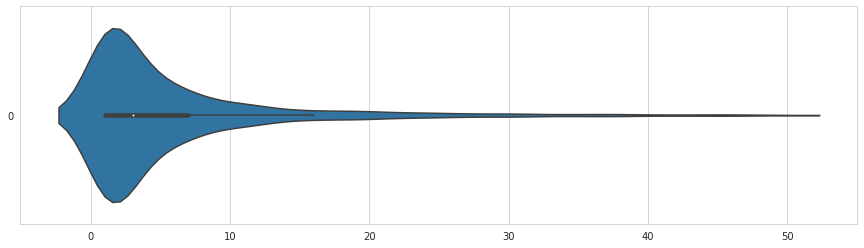

In [49]:
rest_per_street = rests_data.groupby('street',as_index=False)['id'].count()
rest_per_street.columns = ['street', 'n_rests']
plt.figure(figsize=(15, 4))
sns.violinplot(data = rest_per_street[rest_per_street['n_rests'] < 50]['n_rests'], orient = 'h')

In [50]:
print('Судя по графику, под "улицей с большим количеством объектов общественного питания" можно понимать верхние 10% улиц с {:.0f} и более заведениями.'.format(rest_per_street['n_rests'].quantile(0.9)))

Судя по графику, под "улицей с большим количеством объектов общественного питания" можно понимать верхние 10% улиц с 17 и более заведениями.


Создаем новый датафрейм, в который подтягиваем количество ресторанов на каждой улице, и строим графики распределения количества мест в заведении по (а) всем заведениям (оранженвый цвет), и (б) только по заведениям, которые находятся на улице с более чем 17 ресторанами. Все графики ограничены ресторанами до 100 мест.

0.5599807676897187


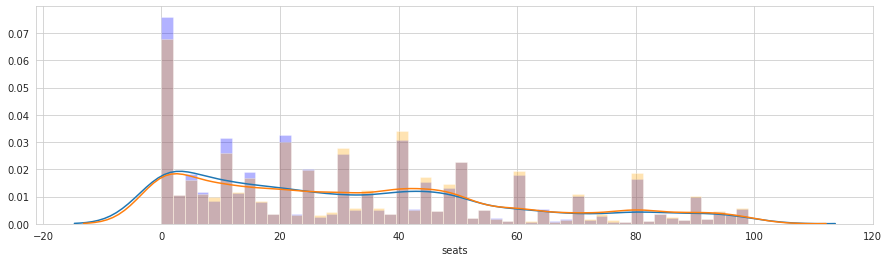

In [51]:
streets_rests = rests_data.merge(rest_per_street, on = 'street', how = 'left')
plt.figure(figsize=(15, 4))
sns.distplot(streets_rests.query('seats < 100 and n_rests > 17')['seats'], hist_kws={"alpha": 0.3, "color": "blue"}, bins = 50)
sns.distplot(streets_rests.query('seats < 100')['seats'], hist_kws={"alpha": 0.3, "color": "orange"}, bins = 50)
print(len(streets_rests.query('seats < 100 and n_rests > 17')) / len(streets_rests.query('seats < 100')))

Как видно на графике, распределение практически совпадает, с той лишь разницей, что на популярных улицах чуть больше маленьких заведений (до 30 мест) и чуть меньше - больших (больше 30 мест). В остальном распределение совпадает. Это ожидаемо, потому что, с одной стороны, на загруженных улицах меньше места для больших ресторанов, а с другой, на 10% самых популярных улиц находится 56% всех ресторанов, поэтому распределение этой выборки не должно сильно отличаться от распределения всей популяции.

## Выводы: <a name="results"></a>

Небольшие (на ~30 посетителей) несетевые (77%) кафе – это наиболее массовые заведения в Москве. Это говорит и об их популярности, и о высокой конкуренции. Необычный формат с роботами может стать успешным конкуретным преимуществом, поэтому имеет смысл не избегать конкуренции, а разместить кафе в одном из наиболее популярных районов - Пресненском, Басманном, Даниловском или Тверском. При успехе первого заведения в дальнейшем можно расширяться, следуя одной из двух стратегий: увеличивать размер кафе или расширять сеть, однако, судя по опыту конкурентов, не то и другое одновременно.

## Интерактивная карта с распределением ресторанов <a name="interactive_map"></a>

[к содержанию](#content)

Создадим интерактивную карту, на который можно будет увидеть количество рестораной в каждом районе.
Для этого будем использовать Яндекс.Геокодер

#### Работа с Яндекс.Геокодер (получение координат ресторанов).

Добавим к этой таблице столбец с координатами каждого ресторана. Для этого воспользуемся API Yandex.Геокодер.
Для работы с ним нам понадобится api-key. Получаем его по ссылке https://developer.tech.yandex.ru/services/ и сохраняем в yaml-файл

In [52]:
# подгружаем токен из файла
from yaml import safe_load

with open('config_Geocoder.yaml') as file:
    token_source = safe_load(file)

# загружаем api-key в переменную
token_Geocoder = token_source['Yandex Maps']['token']

Ключ подгружен. Воспользуемся примером из руководства по использованию API (https://tech.yandex.ru/maps/geocoder/doc/desc/examples/geocoder_examples-docpage/):

"Простой поиск по координатам Запрос с координатами дома по адреса «Тверская 6»:
https://geocode-maps.yandex.ru/1.x/?apikey=ваш API-ключ&geocode=37.611347,55.760241"
Этот запрос и возьмем за основу.

Для отправки запросов и получения ответов воспользуемся стандартной библиотекой requests:

In [53]:
import requests as r

Используем ссылку, взятую из примера, и подгрузим в неё api-key:

In [54]:
url = 'https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode='.format(token_Geocoder)

Для начала предлагаю посмотреть результат отработки функции на одном адресе. Адреса у нас находятся в датафрейме rests в столбце address, посмотрим на первый:

In [55]:
rests_data['address'][0]

'город Москва, улица Егора Абакумова, дом 9'

Берем этот адрес и добавляем его в нашу ссылку в конец:

In [56]:
url_formatted = url + 'город Москва, улица Егора Абакумова, дом 9'

Отправим нашу готовую ссылку Геокодеру, получим ответ в формате .json и выведем его на экран:

In [57]:
response = r.get(url_formatted).json()
response

{'response': {'GeoObjectCollection': {'metaDataProperty': {'GeocoderResponseMetaData': {'request': 'город Москва, улица Егора Абакумова, дом 9',
     'results': '10',
     'found': '1'}},
   'featureMember': [{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'exact',
        'text': 'Россия, Москва, улица Егора Абакумова, 9',
        'kind': 'house',
        'Address': {'country_code': 'RU',
         'formatted': 'Россия, Москва, улица Егора Абакумова, 9',
         'postal_code': '129347',
         'Components': [{'kind': 'country', 'name': 'Россия'},
          {'kind': 'province', 'name': 'Центральный федеральный округ'},
          {'kind': 'province', 'name': 'Москва'},
          {'kind': 'locality', 'name': 'Москва'},
          {'kind': 'street', 'name': 'улица Егора Абакумова'},
          {'kind': 'house', 'name': '9'}]},
        'AddressDetails': {'Country': {'AddressLine': 'Россия, Москва, улица Егора Абакумова, 9',
          'CountryNameCode': 'RU',
         

Просмотрев весь ответ, можно найти в самой последней строке как раз нужные нам координаты.
Формат .json - это смесь из словарей из списков, поэтому будем поэтапно добираться до ключа 'Point':
мы видим, что всё это дело - это словарь с ключом response, получим результат:

In [58]:
response['response']

{'GeoObjectCollection': {'metaDataProperty': {'GeocoderResponseMetaData': {'request': 'город Москва, улица Егора Абакумова, дом 9',
    'results': '10',
    'found': '1'}},
  'featureMember': [{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'exact',
       'text': 'Россия, Москва, улица Егора Абакумова, 9',
       'kind': 'house',
       'Address': {'country_code': 'RU',
        'formatted': 'Россия, Москва, улица Егора Абакумова, 9',
        'postal_code': '129347',
        'Components': [{'kind': 'country', 'name': 'Россия'},
         {'kind': 'province', 'name': 'Центральный федеральный округ'},
         {'kind': 'province', 'name': 'Москва'},
         {'kind': 'locality', 'name': 'Москва'},
         {'kind': 'street', 'name': 'улица Егора Абакумова'},
         {'kind': 'house', 'name': '9'}]},
       'AddressDetails': {'Country': {'AddressLine': 'Россия, Москва, улица Егора Абакумова, 9',
         'CountryNameCode': 'RU',
         'CountryName': 'Россия',
    

In [59]:
# словарь с ключом GeoObjectCollection:
response['response']['GeoObjectCollection']

{'metaDataProperty': {'GeocoderResponseMetaData': {'request': 'город Москва, улица Егора Абакумова, дом 9',
   'results': '10',
   'found': '1'}},
 'featureMember': [{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'exact',
      'text': 'Россия, Москва, улица Егора Абакумова, 9',
      'kind': 'house',
      'Address': {'country_code': 'RU',
       'formatted': 'Россия, Москва, улица Егора Абакумова, 9',
       'postal_code': '129347',
       'Components': [{'kind': 'country', 'name': 'Россия'},
        {'kind': 'province', 'name': 'Центральный федеральный округ'},
        {'kind': 'province', 'name': 'Москва'},
        {'kind': 'locality', 'name': 'Москва'},
        {'kind': 'street', 'name': 'улица Егора Абакумова'},
        {'kind': 'house', 'name': '9'}]},
      'AddressDetails': {'Country': {'AddressLine': 'Россия, Москва, улица Егора Абакумова, 9',
        'CountryNameCode': 'RU',
        'CountryName': 'Россия',
        'AdministrativeArea': {'Administrativ

In [60]:
# теперь нужно выбрать словарь featureMember:
response['response']['GeoObjectCollection']['featureMember']

[{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'exact',
     'text': 'Россия, Москва, улица Егора Абакумова, 9',
     'kind': 'house',
     'Address': {'country_code': 'RU',
      'formatted': 'Россия, Москва, улица Егора Абакумова, 9',
      'postal_code': '129347',
      'Components': [{'kind': 'country', 'name': 'Россия'},
       {'kind': 'province', 'name': 'Центральный федеральный округ'},
       {'kind': 'province', 'name': 'Москва'},
       {'kind': 'locality', 'name': 'Москва'},
       {'kind': 'street', 'name': 'улица Егора Абакумова'},
       {'kind': 'house', 'name': '9'}]},
     'AddressDetails': {'Country': {'AddressLine': 'Россия, Москва, улица Егора Абакумова, 9',
       'CountryNameCode': 'RU',
       'CountryName': 'Россия',
       'AdministrativeArea': {'AdministrativeAreaName': 'Москва',
        'Locality': {'LocalityName': 'Москва',
         'Thoroughfare': {'ThoroughfareName': 'улица Егора Абакумова',
          'Premise': {'PremiseNumber': '

In [61]:
response['response']['GeoObjectCollection']['featureMember'][0]

{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'exact',
    'text': 'Россия, Москва, улица Егора Абакумова, 9',
    'kind': 'house',
    'Address': {'country_code': 'RU',
     'formatted': 'Россия, Москва, улица Егора Абакумова, 9',
     'postal_code': '129347',
     'Components': [{'kind': 'country', 'name': 'Россия'},
      {'kind': 'province', 'name': 'Центральный федеральный округ'},
      {'kind': 'province', 'name': 'Москва'},
      {'kind': 'locality', 'name': 'Москва'},
      {'kind': 'street', 'name': 'улица Егора Абакумова'},
      {'kind': 'house', 'name': '9'}]},
    'AddressDetails': {'Country': {'AddressLine': 'Россия, Москва, улица Егора Абакумова, 9',
      'CountryNameCode': 'RU',
      'CountryName': 'Россия',
      'AdministrativeArea': {'AdministrativeAreaName': 'Москва',
       'Locality': {'LocalityName': 'Москва',
        'Thoroughfare': {'ThoroughfareName': 'улица Егора Абакумова',
         'Premise': {'PremiseNumber': '9',
          'Post

In [62]:
# обратимся к словарю GeoObject:
response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']

{'metaDataProperty': {'GeocoderMetaData': {'precision': 'exact',
   'text': 'Россия, Москва, улица Егора Абакумова, 9',
   'kind': 'house',
   'Address': {'country_code': 'RU',
    'formatted': 'Россия, Москва, улица Егора Абакумова, 9',
    'postal_code': '129347',
    'Components': [{'kind': 'country', 'name': 'Россия'},
     {'kind': 'province', 'name': 'Центральный федеральный округ'},
     {'kind': 'province', 'name': 'Москва'},
     {'kind': 'locality', 'name': 'Москва'},
     {'kind': 'street', 'name': 'улица Егора Абакумова'},
     {'kind': 'house', 'name': '9'}]},
   'AddressDetails': {'Country': {'AddressLine': 'Россия, Москва, улица Егора Абакумова, 9',
     'CountryNameCode': 'RU',
     'CountryName': 'Россия',
     'AdministrativeArea': {'AdministrativeAreaName': 'Москва',
      'Locality': {'LocalityName': 'Москва',
       'Thoroughfare': {'ThoroughfareName': 'улица Егора Абакумова',
        'Premise': {'PremiseNumber': '9',
         'PostalCode': {'PostalCodeNumber': '12

In [63]:
# доступен ключ Point:
response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']

{'pos': '37.714474 55.879005'}

In [64]:
# извлекаем координаты в переменную:
point = response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
point

'37.714474 55.879005'

Получили координаты в формате строки.

Всё-таки нам нужны координаты в числовом формате float, поэтому превратим их в такие.

In [65]:
# Учтем это при работе далее:

latitude = float(point.split()[1].lstrip('('))
longitude = float(point.split()[0].lstrip('('))

print('Широта - {}, долгота - {}'.format(latitude, longitude))

Широта - 55.879005, долгота - 37.714474


Масшатибируем этот процесс на первые 10 строк датафрейма - будем итерировать по каждой строке датафрейма и записывать широту очередной точки в список latitudes, а долготу - в longitudes:

In [66]:
latitudes = []
longitudes = []

for rest_address in rests_data['address'][10]:
    if rest_address == rest_address: # чтоб не столкнуться с nan
        url_formatted = url + 'Москва, ' + rest_address  # на всякий случай добавляем, что это Москва,
                                                         # предполагая, что где-то может быть это не указано
        response = r.get(url_formatted).json()
        try:  # именно через try, чтобы функцию не прекратила работу
            point = response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'].get('pos')
        except:  # если результат не получаем, то идем далее по циклу
            pass
        if point is not None:  # если ответ есть
            latitude = float(point.split()[1].lstrip('('))
            longitude = float(point.split()[0].lstrip('('))
            latitudes.append(latitude)
            longitudes.append(longitude)
        else:  # если ответа не было
            latitudes.append('')
            longitudes.append('')  
    else:  # если ячейка с адресом по очередной строке у нас нулевая
        latitudes.append('')
        longitudes.append('')

In [67]:
# Выведем результат:

latitudes, longitudes

([55.755814,
  55.682412,
  56.293752,
  55.682412,
  56.916389,
  55.753215,
  55.755814,
  55.682412,
  55.738226,
  55.820207,
  55.541041,
  55.766552,
  55.753215,
  55.753215,
  55.766552,
  55.541041,
  55.713152,
  55.766552,
  55.755814,
  55.682412,
  55.531728,
  55.682412,
  56.293752,
  43.350759,
  55.766552,
  55.87092,
  55.753215,
  55.842989,
  55.755814,
  55.713152,
  55.235498,
  55.766552,
  55.753215,
  55.753215,
  56.916389,
  55.682412,
  55.755814,
  55.753215,
  55.755814,
  57.967546],
 [37.617635,
  37.461427,
  37.610566,
  37.461427,
  32.16479,
  37.622504,
  37.617635,
  37.461427,
  37.595797,
  37.546453,
  37.508095,
  37.62342,
  37.622504,
  37.622504,
  37.62342,
  37.508095,
  37.596273,
  37.62342,
  37.617635,
  37.461427,
  38.929526,
  37.461427,
  37.610566,
  132.761333,
  37.62342,
  37.688252,
  37.622504,
  37.513035,
  37.617635,
  37.596273,
  38.291668,
  37.62342,
  37.622504,
  37.622504,
  32.16479,
  37.461427,
  37.617635,
  37.

In [68]:
# Масштабируем весь датафрейм:
#latitudes = []
#longitudes = []

#for rest_address in rests_data['address']:
#    if rest_address == rest_address: # чтоб не столкнуться с nan
#        url_formatted = url + 'Москва, ' + rest_address  # на всякий случай добавляем, что это Москва,
#                                                         # предполагая, что где-то может быть это не указано
#        response = r.get(url_formatted).json()
#        try:  # именно через try, чтобы функцию не прекратила работу
#            point = response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point'].get('pos')
#        except:  # если результат не получаем, то идем далее по циклу
#            pass
#        if point is not None:  # если ответ есть
#            latitude = float(point.split()[1].lstrip('('))
#            longitude = float(point.split()[0].lstrip('('))
#            latitudes.append(latitude)
#            longitudes.append(longitude)
#        else:  # если ответа не было
#            latitudes.append('')
#            longitudes.append('')  
#    else:  # если ячейка с адресом по очередной строке у нас нулевая
#        latitudes.append('')
#        longitudes.append('')

In [69]:
#rests_data['latitude'] = latitudes
#rests_data['longitude'] = longitudes

#Получим следующее:
#rests_data_full = rests_data.copy()

In [70]:
#rests_data_full.to_csv('df_1.csv') 

In [71]:
rests_data_full = pd.read_csv('df_1.csv')
del rests_data_full['Unnamed: 0']
rests_data_full.head(2)

id     name chain  type  \
0  151635  сметана   нет  кафе   
1   77874   родник   нет  кафе   

                                             address  seats  \
0         город Москва, улица Егора Абакумова, дом 9     48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1     35   

                           new_address    city                 street  \
0         улица Егора Абакумова, дом 9  Москва  улица Егора Абакумова   
1  улица Талалихина, дом 2/1, корпус 1  Москва       улица Талалихина   

      code       district   latitude  longitude  
0     10.0    Ярославский  55.879005  37.714474  
1  27540.0  Нижегородский  55.738307  37.673295

Сначала каждому ресторану присвоим свой район по признаку вхождения его координат в один из районов Москвы из датафрейма districts: (датафрейм найден в интернете).

In [72]:
districts = geopandas.read_file('mo.geojson', driver='GeoJSON')
districts.head()

NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0         Киевский  45298555  45945000        Троицкий  45298000   
1   Филёвский Парк  45268595  45328000        Западный  45268000   
2  Новофёдоровское  45298567  45954000        Троицкий  45298000   
3        Роговское  45298575  45956000        Троицкий  45298000   
4     "Мосрентген"  45297568  45953000  Новомосковский  45297000   

        ABBREV_AO              TYPE_MO  \
0        Троицкий            Поселение   
1             ЗАО  Муниципальный округ   
2        Троицкий            Поселение   
3        Троицкий            Поселение   
4  Новомосковский            Поселение   

                                                                                              geometry  
0  MULTIPOLYGON (((36.80310 55.44083, 36.80319 55.44160, 36.80357 55.45162, 36.81253 55.45140, 36.8...  
1  POLYGON ((37.42765 55.74821, 37.42849 55.74875, 37.42958 55.74939, 37.43058 55.74976, 37.43162 5...  
2  POLYGON ((36.80357 55.45162, 36.80451 55.46551, 36.81521 55.46597, 36.81575 55.47516, 36.81592 5...  
3  POLYGON ((36.93724 55.24139, 36.93726 55.24161, 36.93755 55.24195, 36.93794 55.24225, 36.93880 5...  
4  POLYGON ((37.43956 55.62731, 37.44018 55.63042, 37.44059 55.63102, 37.44104 55.63126, 37.44709 5...

Нам нужно название района (столбец NAME) и его область (geometry)

In [73]:
# Подгрузим библиотеку, которая нам поможет определить, в границы (multipolygon) какого района входит каждая точка:
from shapely.geometry import Point

Теперь нужно написать функцию, которая возьмем очередную точку (пару координат) из датафрейма rests и проведет поиск по всему датафрейму districts и найдет, какому району принадлежит данная точка, и вернет его название.

In [74]:
def get_state(row):
    try:
        return districts[districts['geometry'].contains(Point(row.longitude, row.latitude))]['NAME'].values[0]
    except:
        return np.NaN

# итерируем и записываем данные в новый столбец district
rests_data_full['district_coordinates'] = rests_data_full.apply(get_state, axis=1)

Посмотрим, по какому количеству объектов мы не смогли найти вхождений ни в один район Москвы:

In [75]:
rests_data_full[rests_data_full['district_coordinates'].isnull()]

id      name chain      type  \
7698  23762  столовая   нет  столовая   

                                            address  seats  \
7698  город Москва, Интернациональная улица, дом 10    200   

                          new_address    city                   street  \
7698  Интернациональная улица, дом 10  Москва  Интернациональная улица   

        code district   latitude  longitude district_coordinates  
7698  8840.0  Внуково  55.945509  37.330525                  NaN

3 строки. Видимо, они лежат за пределами Москвы, именно поэтому по координатам не вошли ни в один район города. Оставим как есть:

In [76]:
# Сгруппируем рестораны по районам и найдем их количество в каждом из них:

rests_gr = rests_data_full.groupby('district_coordinates')['id'].count().reset_index().rename(columns={'id': 'No. rests'})
rests_gr

district_coordinates  No. rests
0           "Мосрентген"         17
1          Академический        125
2           Алексеевский        127
3           Алтуфьевский         32
4                  Арбат        268
..                   ...        ...
141         Южное Тушино        114
142         Южнопортовый        111
143             Якиманка        190
144          Ярославский         98
145              Ясенево        110

[146 rows x 2 columns]

In [77]:
# Добавим эту информацию к датафрейму с границами районов, чтобы потом отобразить эту информацию на карте:

districts = districts.merge(rests_gr, left_on="NAME", right_on="district_coordinates")
districts

NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0            Киевский  45298555  45945000        Троицкий  45298000   
1      Филёвский Парк  45268595  45328000        Западный  45268000   
2     Новофёдоровское  45298567  45954000        Троицкий  45298000   
3           Роговское  45298575  45956000        Троицкий  45298000   
4        "Мосрентген"  45297568  45953000  Новомосковский  45297000   
..                ...       ...       ...             ...       ...   
141        Ивановское  45263567  45306000       Восточный  45263000   
142  Косино-Ухтомский  45263573  45308000       Восточный  45263000   
143        Новокосино  45263579  45310000       Восточный  45263000   
144        Некрасовка  45290574  45391000   Юго-Восточный  45290000   
145           Кунцево  45268562  45320000        Западный  45268000   

          ABBREV_AO              TYPE_MO  \
0          Троицкий            Поселение   
1               ЗАО  Муниципальный округ   
2          Троицкий            Поселение   
3          Троицкий            Поселение   
4    Новомосковский            Поселение   
..              ...                  ...   
141             ВАО  Муниципальный округ   
142             ВАО  Муниципальный округ   
143             ВАО  Муниципальный округ   
144            ЮВАО  Муниципальный округ   
145             ЗАО  Муниципальный округ   

                                                                                                geometry  \
0    MULTIPOLYGON (((36.80310 55.44083, 36.80319 55.44160, 36.80357 55.45162, 36.81253 55.45140, 36.8...   
1    POLYGON ((37.42765 55.74821, 37.42849 55.74875, 37.42958 55.74939, 37.43058 55.74976, 37.43162 5...   
2    POLYGON ((36.80357 55.45162, 36.80451 55.46551, 36.81521 55.46597, 36.81575 55.47516, 36.81592 5...   
3    POLYGON ((36.93724 55.24139, 36.93726 55.24161, 36.93755 55.24195, 36.93794 55.24225, 36.93880 5...   
4    POLYGON ((37.43956 55.62731, 37.44018 55.63042, 37.44059 55.63102, 37.44104 55.63126, 37.44709 5...   
..                                                                                                   ...   
141  POLYGON ((37.79981 55.76232, 37.79981 55.76243, 37.79999 55.76291, 37.80022 55.76347, 37.80036 5...   
142  POLYGON ((37.83602 55.70978, 37.83620 55.71008, 37.83653 55.71068, 37.83777 55.71312, 37.83819 5...   
143  POLYGON ((37.84042 55.73049, 37.84063 55.73196, 37.84165 55.74049, 37.84181 55.74303, 37.84201 5...   
144  POLYGON ((37.90613 55.70626, 37.90701 55.70699, 37.91925 55.70761, 37.92067 55.70780, 37.92192 5...   
145  MULTIPOLYGON (((37.29050 55.80199, 37.29542 55.80300, 37.29663 55.80320, 37.29777 55.80335, 37.2...   

    district_coordinates  No. rests  
0               Киевский          3  
1         Филёвский Парк        105  
2        Новофёдоровское          4  
3              Роговское          5  
4           "Мосрентген"         17  
..                   ...        ...  
141           Ивановское         58  
142     Косино-Ухтомский         55  
143           Новокосино         35  
144           Некрасовка         29  
145              Кунцево        113  

[146 rows x 10 columns]

### Прорисовка карты:

Рисуем тепловую карту ресторанов по районам Москвы

Создаем пустую карту с начальной точки и зумом:

In [78]:
m = folium.Map(location=[55.753215, 37.622504], zoom_start=10)

Возпользуемся методом Choropleth их библиотеки folium и отрисуем тепловую карту по районам. Параметры этого метода:

 - geo_data - геоданные (в том числе, и откуда берем координаты границ районов);
 - name - название слоя карты, на котором будем отображать эту тепловую карту;
 - data - таблица, из которой вытаскиваем данные, которые будут отображаться при наведении курсора на определенный район;
 - columns - столбцы из таблицы, указанной в параметре data, откуда берем данные - один столбец (district), по который используем для джойна с geo_data (следующий параметр - key_on), второй столбец - числовые данные, по которым категоризируем наши районы и даем им определенный цвет в соответствии, в нашем случае, с количеством ресторанов, находящихся в районе;
 - key_on - по какому столбцу джойним geo_data и data (feature.properties - дефолтная часть строки, .NAME - уже изменяемая её часть);
 - fill_color - цветовая палитра заливки;
 - fill_opacity - прозрачность заливки;
 - line_opacity - прозрачность линий границ районов;
 - bins - список числовых значений, которые являются границами интервалов, на которые будут разбиты все районы по количеству рестораны, находящихся в них:

In [79]:
folium.Choropleth(
    geo_data=districts,
    name='choropleth',
    data=rests_gr,
    columns=['district_coordinates', 'No. rests'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.4
).add_to(m)

m

In [80]:
# Задаем bin'ы:
bins = [1, 10, 60, 100, 200, 350, 600, 850] 

Отрисуем карту ещё раз (новый слой):

In [81]:
m = folium.Map(location=[55.753215, 37.622504], zoom_start=10)

bins = [1, 10, 60, 100, 200, 350, 600, 850]  # bins (кол-во ресторанов в районе) для интенсивности цвета заливки 
                                             # каждого конкретного района

folium.Choropleth(
    geo_data=districts,
    name='choropleth',
    data=rests_gr,
    columns=['district_coordinates', 'No. rests'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.4,
    bins=bins
).add_to(m)

m

Отображение указателей районов и информации по ним (всплывающие окна).

Воспользуемся методом GeoJson. Параметры этого метода:

сначала идем датафрейм с геоданными (и всем остальными нужными нам данными) по районам;
- name - название слоя;
- style_function - какой стиль будет применяться для отрисовки районов и его границ;
- tooltip - какая информация будет отображаться при наведении мышки на район:
- fields - столбцы из датафрейма, указанного в первом параметре, данные из которого мы будем брать для отображения;
- aliases - как мы назовем эти столбцы во всплывающем окне;
- localize - форматирование некоторых числовых данных (например, 1000000 превращает в более удобный для прочтения 1,000,000);
- smooth_factor - как у нас отображаются границы при каждом следующем зуме. Чем меньше, тем оперативней работает карта.

In [82]:
folium.GeoJson(
    districts,
    name='district_coordinates',
    style_function=None,
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'NAME_AO', 'No. rests'],
        aliases=['Район', 'Округ', 'Кол-во ресторанов'], 
        localize=False
    ),
    smooth_factor = 0
).add_to(m)

m

In [83]:
# зададим параметр style_function таким образом, чтобы все области и границы отображались прозрачными:

style_function = lambda x: {
    'fillColor': 'ffffff',
    'color': 'black',
    'weight': 0,
    'fillOpacity': 0
}

In [84]:
# Рисуем карту:

m = folium.Map(location=[55.753215, 37.622504], zoom_start=10)

bins = [1, 10, 60, 100, 200, 350, 600, 850]  # bins (кол-во ресторанов в районе) для интенсивности цвета заливки 
                                             # каждого конкретного района

folium.Choropleth(
    geo_data=districts,
    name='choropleth',
    data=rests_gr,
    columns=['district_coordinates', 'No. rests'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.4,
    bins=bins
).add_to(m)




style_function = lambda x: {
    'fillColor': 'ffffff',
    'color': 'black',
    'weight': 0,
    'fillOpacity': 0
}

districtgeo = folium.GeoJson(
    districts,
    name='district_coordinates',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'NAME_AO', 'No. rests'],
        aliases=['Район', 'Округ', 'Кол-во ресторанов'], 
        localize=False
    ),
    smooth_factor = 0
).add_to(m)

m

Карта готова, но долго загружается при зуме.

Карта "тормозит", особенно при зумах (и не отобразится через nbviewer через браузер Chrome, т.к. у него стоит ограничение в 2 Мб для отображения html-элементов).

Чтобы это исправить, сохраним карту в формате .html, а потом подгрузим её обратно сюда из файла:

In [85]:
m.save('folium_map_v1.html')

In [86]:
# Подгружаем:
IFrame('folium_map_v1.html', width='100%', height='750px')

У нас получилась интерактивная карта. При наведении курсором можно увидеть название района, округа и количество ресторанов.

## Шаг №3. Презентация <a name="step_3"></a>

[к содержанию](#content)

Презентация доступна по ссылке https://yadi.sk/i/oJ2a6yqKCjb2lA